In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
base_url = '../datasets'

In [3]:
# reading csv
juan = pd.read_csv(f'{base_url}/vulns-labelled-juan.csv')
anderson = pd.read_csv(f'{base_url}/vulns-labelled-anderson.csv')
joel = pd.read_csv(f'{base_url}/vulns-labelled-joel.csv')

In [4]:
# sort and reseting index values
juan.sort_values(by=['cve_id'], inplace=True)
juan.reset_index(drop=True, inplace=True)

anderson.sort_values(by=['cve_id'], inplace=True)
anderson.reset_index(drop=True, inplace=True)

joel.sort_values(by=['cve_id'], inplace=True)
joel.reset_index(drop=True, inplace=True)

In [5]:
# dropping label column to compare dataframes
tmp_anderson = anderson.drop(columns=['label'])
tmp_joel = joel.drop(columns=['label'])
tmp_juan = juan.drop(columns=['label'])

In [6]:
# comparing dataframes
tmp_juan.equals(tmp_anderson), tmp_anderson.equals(tmp_joel), tmp_joel.equals(tmp_juan)

(True, True, True)

In [7]:
# selecting labels to comparison
anderson_labels = anderson['label'].tolist()
joel_labels = joel['label'].tolist()
juan_labels = juan['label'].tolist()

In [8]:
# simulating voting
n = len(juan)
labels = list()

majority = 0

anderson_error = 0
juan_error = 0
joel_error = 0

for i in range(n):
    tmp = np.array([
        anderson_labels[i], juan_labels[i], joel_labels[i]
    ], dtype='object')
    
    values, counts = np.unique(tmp, return_counts=True)

    max_count_index = counts.argmax()
    max_count_value = counts[max_count_index]
    
    if values[max_count_index] == 'IMPORTANT':
        if values[max_count_index] != anderson_labels[i]:
            anderson_error += 1
        elif values[max_count_index] != juan_labels[i]:
            juan_error += 1
        elif values[max_count_index] != joel_labels[i]:
            joel_error += 1
    
    if max_count_value >= 2:
        labels.append(values[max_count_index])
        majority += 1
    else:
        labels.append('discard')

In [9]:
labels = np.array(labels)

In [10]:
# replacing labels
majority = juan.copy()

majority['label'] = labels

# discarding entries that were not majority vote
majority = majority.loc[majority['label'] != 'discard']

In [11]:
print(f'Achieved majority: {majority.shape[0]} ({majority.shape[0] / 260})')

Achieved majority: 208 (0.8)


In [12]:
# results
for item in ['LOW', 'MODERATE', 'IMPORTANT', 'CRITICAL']:
    count = majority.loc[majority['label'] == item].shape[0]
    print(f'  - {item}: {count} ({count / majority.shape[0]:.2f}%)')

  - LOW: 60 (0.29%)
  - MODERATE: 45 (0.22%)
  - IMPORTANT: 45 (0.22%)
  - CRITICAL: 58 (0.28%)


In [13]:
juan = juan.loc[juan['cve_id'].isin(majority['cve_id'].tolist())]
anderson = anderson.loc[anderson['cve_id'].isin(majority['cve_id'].tolist())]
joel = joel.loc[joel['cve_id'].isin(majority['cve_id'].tolist())]

In [14]:
juan_acc = juan.where(juan.values == majority.values)['label'].count()
print(f'First Analyst acc = {juan_acc / majority.shape[0]:.2f}')

anderson_acc = anderson.where(anderson.values == majority.values)['label'].count()
print(f'Second Analyst acc = {anderson_acc / majority.shape[0]:.2f}')

joel_acc = joel.where(joel.values == majority.values)['label'].count()
print(f'Third Analyst acc = {joel_acc / majority.shape[0]:.2f}')

First Analyst acc = 0.75
Second Analyst acc = 0.76
Third Analyst acc = 0.74


In [15]:
juan_cm = list()
anderson_cm = list()
joel_cm = list()

def cm_row(df, absolute=False):
    row = list()
    
    for item in ['LOW', 'MODERATE', 'IMPORTANT', 'CRITICAL']:
        count = df.loc[df['label'] == item].shape[0]
        acc = count if absolute else count / df.shape[0]
        row.append(acc)
        
    return row

ABSOLUTE = False

for item in ['LOW', 'MODERATE', 'IMPORTANT', 'CRITICAL']:
    curr = majority.loc[majority['label'] == item]

    curr_juan = juan.loc[juan['cve_id'].isin(curr['cve_id'].tolist())]
    juan_cm.append(cm_row(curr_juan, ABSOLUTE))
    
    curr_anderson = anderson.loc[anderson['cve_id'].isin(curr['cve_id'].tolist())]
    anderson_cm.append(cm_row(curr_anderson, ABSOLUTE))
    
    curr_joel = joel.loc[joel['cve_id'].isin(curr['cve_id'].tolist())]
    joel_cm.append(cm_row(curr_joel, ABSOLUTE))

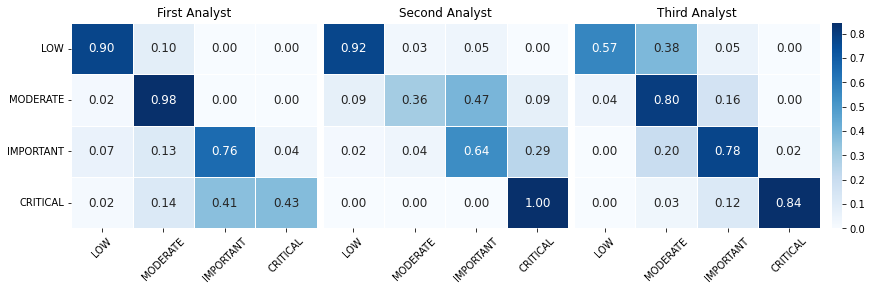

In [16]:
labels = ['LOW', 'MODERATE', 'IMPORTANT', 'CRITICAL']
titles = ['First Analyst', 'Second Analyst', 'Third Analyst']

cms = [juan_cm, anderson_cm, joel_cm]

fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

fig.suptitle('', size=14)

for index, (axe, cm_values, title) in enumerate(zip(axes, cms, titles)):
    yticks = labels if index == 0 else False
    draw_cbar = True if index == 2 else False

    axe.set_title(title)
    axe = sns.heatmap(cm_values, ax=axe, annot=True, fmt=".2f", linewidths=.5, cmap=plt.cm.Blues, 
                      yticklabels=yticks, xticklabels=labels, cbar=draw_cbar, annot_kws={"size": 12})

    axe.set_xticklabels(axe.get_xticklabels(), rotation=45)
    axe.set_yticklabels(axe.get_yticklabels(), rotation=0)
plt.show()

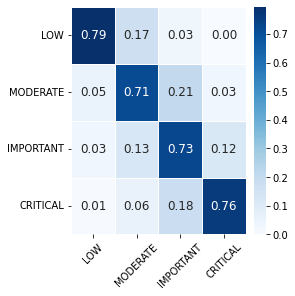

In [17]:
cm_mean = np.array(juan_cm) + np.array(anderson_cm) + np.array(joel_cm)
cm_mean /= 3

labels = ['LOW', 'MODERATE', 'IMPORTANT', 'CRITICAL']

fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)

# ax.set_title('Mean CM')
ax = sns.heatmap(cm_mean, ax=ax, annot=True, fmt=".2f", linewidths=.5, cmap=plt.cm.Blues, 
                  yticklabels=labels, xticklabels=labels, cbar=True, annot_kws={"size": 12})

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.savefig('analists-cm.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## saving to csv

In [18]:
# majority.to_csv('vulns-labelled.csv', index=False)